In [1]:
import multiprocessing
from pandarallel import pandarallel
num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 8


In [ ]:
# pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed


seed(1)

In [48]:
artists = pd.read_csv('/Users/linhle/Documents/Practice Projects/Artist Detection/archive/artists.csv')
artists.shape

(50, 8)

In [49]:
artists.paintings.sum()

8446

### 1. EDA

In [51]:
artists.paintings.describe()

count     50.000000
mean     168.920000
std      157.451105
min       24.000000
25%       81.000000
50%      123.000000
75%      191.750000
max      877.000000
Name: paintings, dtype: float64

In [4]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [37]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [38]:
# Explore images of top artists
images_dir = '/Users/linhle/Documents/Practice Projects/Artist Detection/archive/images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /Users/linhle/Documents/Practice Projects/Artist Detection/archive/images/images/Vincent_van_Gogh
Found --> /Users/linhle/Documents/Practice Projects/Artist Detection/archive/images/images/Edgar_Degas
Found --> /Users/linhle/Documents/Practice Projects/Artist Detection/archive/images/images/Pablo_Picasso
Found --> /Users/linhle/Documents/Practice Projects/Artist Detection/archive/images/images/Pierre-Auguste_Renoir
Found --> /Users/linhle/Documents/Practice Projects/Artist Detection/archive/images/images/Albrecht_Dürer
Found --> /Users/linhle/Documents/Practice Projects/Artist Detection/archive/images/images/Paul_Gauguin
Found --> /Users/linhle/Documents/Practice Projects/Artist Detection/archive/images/images/Francisco_Goya
Found --> /Users/linhle/Documents/Practice Projects/Artist Detection/archive/images/images/Rembrandt
Found --> /Users/linhle/Documents/Practice Projects/Artist Detection/archive/images/images/Alfred_Sisley
Found --> /Users/linhle/Documents/Practice Projec

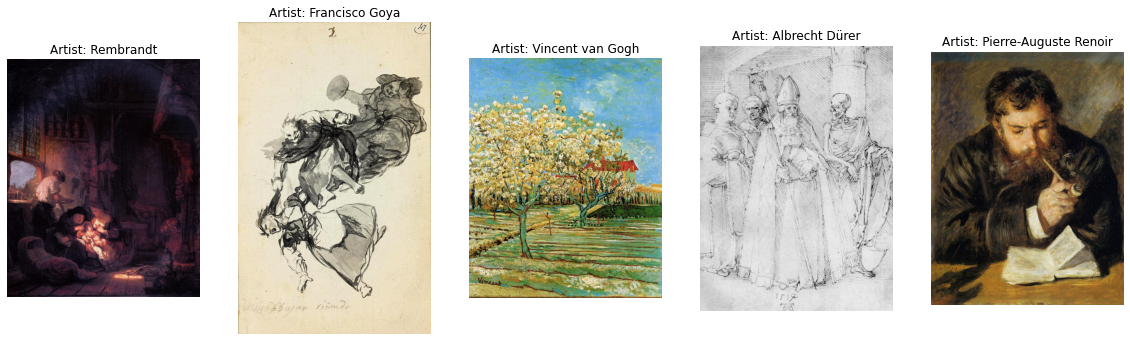

In [7]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [46]:
!pip3 install opencv-python

     |████████████████████████████████| 53.9 MB 802 kB/s eta 0:00:013


In [62]:
import os
import cv2
import numpy as np

# Define the image directory path
images_dir = '/Users/linhle/Documents/Practice Projects/Artist Detection/archive/images/images'

# Get a list of all artist directories
artists_dirs = [d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))]

# Define a list to store the mean and standard deviation of each image
image_stats = []

# Loop through each artist directory
for artist_dir in artists_dirs:
    # Get a list of all image files in the artist directory
    artist_images = [f for f in os.listdir(os.path.join(images_dir, artist_dir)) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    
    # Loop through each image file
    for image_file in artist_images:
        # Load the image using OpenCV
        image_path = os.path.join(images_dir, artist_dir, image_file)
        image = cv2.imread(image_path)
        
        # Calculate the mean and standard deviation of the image pixel intensities
        image_mean = np.mean(image.shape[:2])
        image_std = np.std(image.shape[:2])
        image_min = np.min(image.shape[:2])
        image_max = np.max(image.shape[:2])
        
        # Add the image statistics to the list
        image_stats.append((image_mean, image_std,image_min,image_max))

# Calculate the overall mean and standard deviation of all the images
mean = np.mean([stat[0] for stat in image_stats])
std = np.mean([stat[1] for stat in image_stats])
imin = np.min([stat[2] for stat in image_stats])
imax = np.max([stat[3] for stat in image_stats])

# Print the results
print(f"Mean: {mean:.2f}")
print(f"Standard Deviation: {std:.2f}")
print(f"Min: {imin:.2f}")
print(f"Max: {imax:.2f}")


Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


Mean: 950.59
Standard Deviation: 140.74
Min: 204.00
Max: 4096.00


In [61]:
image.shape[:2]

(1024, 1188)

In [63]:
artists.genre.unique()

array(['Post-Impressionism', 'Impressionism', 'Cubism',
       'Northern Renaissance', 'Symbolism,Post-Impressionism',
       'Romanticism', 'Baroque', 'High Renaissance,Mannerism',
       'Primitivism', 'Surrealism,Impressionism', 'Expressionism',
       'Expressionism,Abstractionism,Surrealism',
       'Impressionism,Post-Impressionism', 'Pop Art', 'Symbolism',
       'Early Renaissance', 'High Renaissance', 'Surrealism',
       'Suprematism', 'Primitivism,Surrealism', 'Proto Renaissance',
       'Symbolism,Art Nouveau', 'Byzantine Art', 'Realism,Impressionism',
       'Expressionism,Abstractionism', 'Mannerism', 'Neoplasticism',
       'Social Realism,Muralism', 'Symbolism,Expressionism', 'Realism',
       'Abstract Expressionism'], dtype=object)

### Data Augmentation

In [8]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3444 images belonging to 11 classes.
Found 855 images belonging to 11 classes.
Total number of batches = 215 and 53


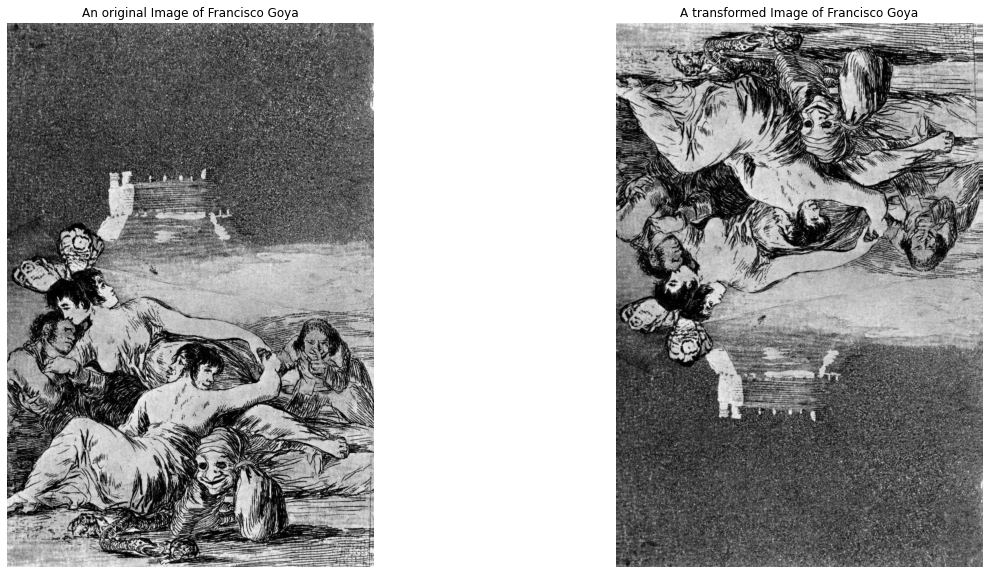

In [9]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

### Build Model

#### Baseline: CNN

In [4]:
batch_size = 16
train_input_shape = (224, 224, 3)

In [5]:
train_input_shape[0:2]

(224, 224)

In [6]:
classifier = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, 
                           kernel_size=(3, 3),
                           input_shape=train_input_shape,
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, 
                           kernel_size=(3, 3),
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=11, activation='softmax')
])


In [7]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [24]:
        # define and compile your model here
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        # fit the model with the current epoch and step values
history = classifier.fit(train_generator, epochs=50, steps_per_epoch=STEP_SIZE_TRAIN, 
                                 validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                 class_weight=class_weights)
test_loss, test_acc = classifier.evaluate(valid_generator)
        
        # print the results
print(f"Epochs: {epoch}, Steps per epoch: {step}, Test accuracy: {test_acc}")



Epoch 1/50
215/215 [==============================] - 102s 469ms/step - loss: 0.5217 - accuracy: 0.8127 - val_loss: 1.6477 - val_accuracy: 0.5696
Epoch 2/50
215/215 [==============================] - 98s 454ms/step - loss: 0.3812 - accuracy: 0.8489 - val_loss: 1.8349 - val_accuracy: 0.5613
Epoch 3/50
215/215 [==============================] - 99s 458ms/step - loss: 0.3978 - accuracy: 0.8468 - val_loss: 1.7630 - val_accuracy: 0.5366
Epoch 4/50
215/215 [==============================] - 99s 458ms/step - loss: 0.3289 - accuracy: 0.8722 - val_loss: 1.7790 - val_accuracy: 0.5672
Epoch 5/50
215/215 [==============================] - 98s 454ms/step - loss: 0.2424 - accuracy: 0.9008 - val_loss: 2.0388 - val_accuracy: 0.5330
Epoch 6/50
215/215 [==============================] - 97s 452ms/step - loss: 0.2662 - accuracy: 0.8903 - val_loss: 2.2286 - val_accuracy: 0.5531
Epoch 7/50
215/215 [==============================] - 97s 453ms/step - loss: 0.2974 - accuracy: 0.8894 - val_loss: 2.1011 - val_a

In [29]:
print(f'Test metrics for Baseline CNN: Loss: {test_loss}, Accuracy: {test_acc}')

Test metrics for Baseline CNN: Loss: 3.720187187194824, Accuracy: 0.5356724858283997
